In [1]:
import os
import re
import json
from copy import deepcopy
from collections import Counter
from multiprocessing import Pool

import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

tqdm.pandas()

In [2]:
data_folder = os.path.join('..', '..', 'data')
data_folder

'../../data'

In [3]:
data_path = os.path.join(data_folder, 'mfcc_data')
data_path

'../../data/mfcc_data'

In [4]:
dfs = {'aa': None, 'ee': None, 'oo': None, 'uu': None, 'yy': None}

def get_df(key):
    df = pd.read_csv(os.path.join(data_path, f'{key}.csv'))
    df['mb_name'] = df['mb_name'].apply(lambda name: name.lower())
    df.rename(columns = {'Unnamed: 0':'per_frame_idx'}, inplace = True)
    return (key, df)

def update_dfs(x):
    key, df = x
    dfs[key] = df

In [5]:
read_pool = Pool()
for key in dfs.keys():
    read_pool.apply_async(get_df, args=(key,) , callback=update_dfs)
read_pool.close()
read_pool.join()


In [6]:
patients = {'aa': None, 'ee': None, 'oo': None, 'uu': None, 'yy': None}
control = {'aa': None, 'ee': None, 'oo': None, 'uu': None, 'yy': None}

for key, df in dfs.items():
    patients[key] = df.loc[df['asthma_status'] == 'Patient']
    control[key] = df.loc[df['asthma_status'] == 'Control']

    n_p = patients[key]['mb_name'].nunique()
    n_c = control[key]['mb_name'].nunique()

    print(f'phonon {key}: p = {n_p}, c = {n_c}')

phonon aa: p = 65, c = 103
phonon ee: p = 65, c = 101
phonon oo: p = 63, c = 103
phonon uu: p = 62, c = 98
phonon yy: p = 62, c = 101


In [7]:
metadata_dir_path = os.path.join(data_folder, 'SHIVANI_DATA_2016')
metadata_dir_path

'../../data/SHIVANI_DATA_2016'

In [8]:
subjects = dict([])

for name in os.listdir(metadata_dir_path):
    name_path = os.path.join(metadata_dir_path, name)
    metadata_path = None

    a, b, c = False, False, False
    for file in os.listdir(name_path):
        if re.match('^.+before.+[.]wav$', file) != None: a = True
        if re.match('^.+before.+[.]anote[.]txt$', file) != None: b = True
        if re.match('^.+[.]json$', file) != None: 
            c = True
            metadata_path = os.path.join(name_path, file)

    if a and b and c:
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)['subjectBiodata']

            # fill deatils about the subjects
            subjects[name.lower()] = {
                'age': metadata['subjectAge'],
                'gender': metadata['subjectGender'],
                'type': metadata['subjectType']
            }

#### Visualize

In [9]:
patient_ages = [data['age'] for names, data in subjects.items() if data['type'] == 'Patient']
contol_ages = [data['age'] for names, data in subjects.items() if data['type'] == 'Control']

patient_mean_age = round(np.mean(patient_ages))
control_mean_age = round(np.mean(contol_ages))
print(f'Mean age of contol is {control_mean_age}')
print(f'Mean age of patients is {patient_mean_age}')

patient_median_age = round(np.median(patient_ages))
control_median_age = round(np.median(contol_ages))
print(f'Median age of contol is {control_median_age}')
print(f'Median age of patients is {patient_median_age}')


Mean age of contol is 30
Mean age of patients is 42
Median age of contol is 26
Median age of patients is 40


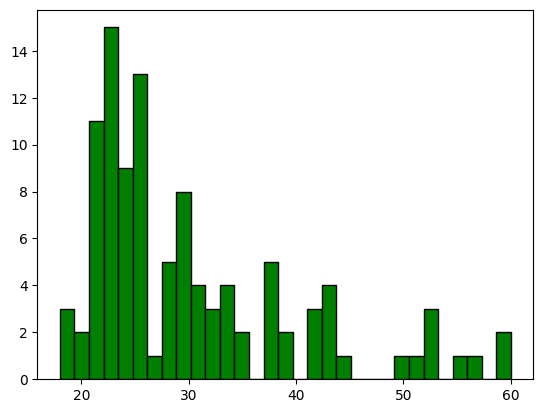

In [10]:
plt.hist(contol_ages, color='green', ec='black', bins=len(set(contol_ages)))
plt.show()

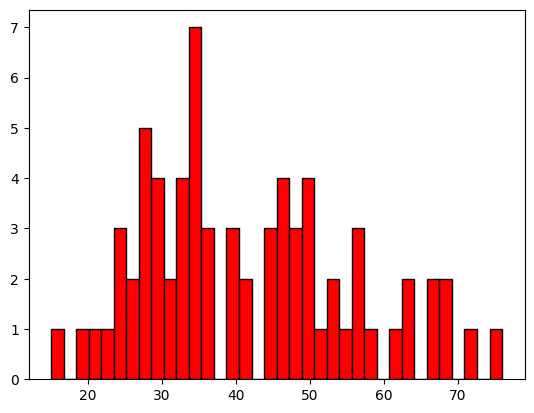

In [11]:
plt.hist(patient_ages, color='red', ec='black', bins=len(set(patient_ages)))
plt.show()

In [12]:
patient_genders = [data['gender'] for names, data in subjects.items() if data['type'] == 'Patient']
contol_genders = [data['gender'] for names, data in subjects.items() if data['type'] == 'Control']

print(f'Gender num for control {Counter(contol_genders)}')
print(f'Gender num for patients {Counter(patient_genders)}')

Gender num for control Counter({'male': 55, 'female': 49})
Gender num for patients Counter({'male': 39, 'female': 31})


In [13]:
def conv_to_32(df, cols):
    df[cols] = df[cols].astype(np.float32)

conv_to_32(dfs['aa'], ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12'])

In [14]:
save_folder = os.path.join(data_path, 'split_samples')
save_folder

'../../data/mfcc_data/split_samples'

In [15]:
for key, df in tqdm(dfs.items()):
    X = dfs['aa'].loc[:, ['mb_name']]
    Y = dfs['aa'].loc[:, ['asthma_status']]

    # convert from pandas to 1D numpy
    X_np = X.to_numpy().flatten()
    Y_np = Y.to_numpy().flatten()

    k = list(set((zip(X_np, Y_np)))) # get unique pairs

    # split the unique pairs
    m = list(zip(*k)) 
    x_np = np.array(m[0])
    y_np = np.array(m[1])

    # stratified split
    x_train, x_vt, y_train, y_vt = train_test_split(x_np, y_np, test_size=0.3, random_state=137, stratify=y_np)
    x_val, x_test, y_val, y_test = train_test_split(x_vt, y_vt, test_size=0.33, random_state=137, stratify=y_vt)

    train_df = df.loc[df['mb_name'].isin(x_train)]
    val_df = df.loc[df['mb_name'].isin(x_val)]
    test_df = df.loc[df['mb_name'].isin(x_test)]

    # save files
    train_df.to_csv(os.path.join(save_folder, key, 'train.csv'), header=True, index=False)
    val_df.to_csv(os.path.join(save_folder, key, 'validation.csv'), header=True, index=False)
    test_df.to_csv(os.path.join(save_folder, key, 'test.csv'), header=True, index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:42<00:00,  8.47s/it]
